## CuffDiff Summary
### Author: Xiang Li



In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
### Scatter Plot

import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 
from scipy.stats import gaussian_kde
# display plots in this notebook
%matplotlib inline

In [3]:
# For any input of /gene_exp.diff, return its All genes with
### gene_id, cond1, cond2, log2(fold_change), p_value, plus a number of order.
def generate_All_Genes(Input_Path, number):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2','value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Rename columns
    df=df.rename(columns={'test_id':'gene_id', 'value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output   
    return df.loc[:,['gene_id',df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)',
                     'p_value','q_value', 'End_'+str(number), '||']].fillna('')
####################################################################################


### For any input of /gene_exp.diff, return its up_DEGs genes with
### gene_id, cond1, cond2, log2(fold_change), p_value, plus a number of order.
### Parameters for DEGs:
FC_UP=1.5
q_value_less=0.05
FPKM_threshold=1.0
####################################################################################

def generate_Upregulated_Genes(Input_Path):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2', 'value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Filter
    df=df[(df['status']=='OK') & (df['q_value']<=q_value_less) & (df['value_2']>=FPKM_threshold) & (df['log2(fold_change)'] >= np.log2(FC_UP))]
#### Rearrange Columns
    df=df.rename(columns={'test_id':'gene_id','value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output
    return df.loc[:,['gene_id', df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)','p_value','q_value']]
####################################################################################

def generate_Downregulated_Genes(Input_Path):
#### READ FILE FROM CuffDiff Results
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2', 'value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Filter
    df=df[(df['status']=='OK') & (df['q_value']<=q_value_less) & (df['value_1']>=FPKM_threshold) & (df['log2(fold_change)']<= -np.log2(FC_UP))]   
#### Rearrange Columns
    df=df.rename(columns={'test_id':'gene_id','value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output
    return df.loc[:,['gene_id', df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)','p_value','q_value']]


#### Functions to read /genes.read_group_tracking and output FPKM
def generate_genes_FPKM_df(INPUT_PATH):
    df = pd.read_csv(INPUT_PATH+'/genes.read_group_tracking', sep='\t', header=0)
    FPKM_df = None
    for cond in df['condition'].unique():
        for replica in df[df['condition'] == cond]['replicate'].unique():
            #print (cond, replica)
            temp_df = (df[ (df['condition'] == cond) & (df['replicate'] == replica)].loc[:,['tracking_id', 'FPKM']])
            cond_name= cond+'_'+str(replica)
            temp_df.rename(columns={'tracking_id': 'gene_id', 'FPKM': cond_name }, inplace=True)
            if FPKM_df is None:
                FPKM_df
                FPKM_df = temp_df  
            else:
                FPKM_df = FPKM_df.merge(temp_df, on='gene_id', how='outer', suffixes=('','_'))
    return FPKM_df

def Add_common_header(df,common_header):
    name_list=[common_header]*len(df.columns)
    tuples = list(zip(name_list,df.columns))
    df.columns = pd.MultiIndex.from_tuples(tuples)
    return df


def DIR_CHECK_CREATE(Input_Path):
    if (not os.path.isdir(Input_Path)):
        print ("New Dir Made is" + Input_Path)
        os.mkdir(Input_Path)
    else: 
        print ('Dir Exists')

In [129]:
PATH_FOLDER=os.getcwd()+ '/Tfh_Day8/'
OUT_FOLDER=os.getcwd()+'/RPKM_Tfh_Day8/'

DIR_CHECK_CREATE(PATH_FOLDER)
DIR_CHECK_CREATE(OUT_FOLDER)
FPKM_Day8 = generate_genes_FPKM_df(PATH_FOLDER)
FPKM_Day8

FPKM_Day8['WT_Tfh_Day8'] = (FPKM_Day8.iloc[:,1]+FPKM_Day8.iloc[:,2]) / 2
FPKM_Day8['EKO_Tfh_Day8'] =(FPKM_Day8.iloc[:,3]+FPKM_Day8.iloc[:,4]) / 2

FPKM_Day8 = FPKM_Day8[ (FPKM_Day8[['WT_Tfh_Day8','EKO_Tfh_Day8']] >=0.01).all(1)]


Dir Exists
Dir Exists


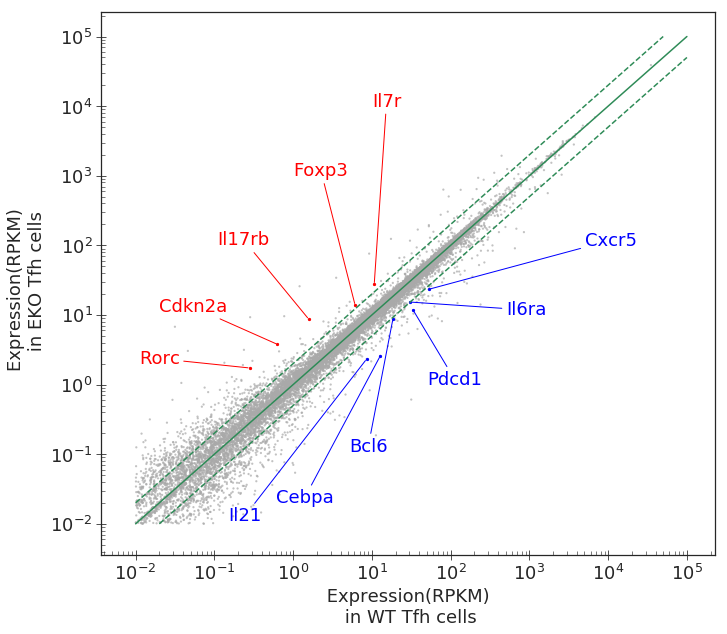

In [280]:
### Using Log10 x, y axis

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,10))
ax.scatter((FPKM_Day8['WT_Tfh_Day8']), (FPKM_Day8['EKO_Tfh_Day8'])
          , alpha=0.7,s=5, label='Tfh Day8',edgecolor='', c='darkgrey')
ax.set_xlabel(' Expression(RPKM) \n in WT Tfh cells', fontsize='18')
ax.set_ylabel('Expression(RPKM)  \n in EKO Tfh cells', fontsize='18')

#ax.legend(loc=2, fontsize=16)


Up_highlight_index_set=['Rorc', 'Cdkn2a', 'Il17rb', 'Foxp3', 'Il7r']
down_highlight_index_set=['Il21', 'Cebpa', 'Bcl6','Pdcd1','Il6ra', 'Cxcr5' ]


i=0
#np.pi / 6
for highlight_index in Up_highlight_index_set:
    #print highlight_index
    ax.scatter( (FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8'] ),
                (FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8']),
            alpha=1.0,s=5,color='r', label=highlight_index,edgecolor='r')
                  
    ax.annotate(highlight_index, color='r', fontsize='18', arrowprops=dict(facecolor='None', edgecolor='red', arrowstyle='-'),
               xy=((FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8'] ),
                (FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8'])), 
               xytext=(10**(-2)+ 10**(i-3), 1 + 10**(i)))
    i+=1

i=0
for highlight_index in down_highlight_index_set:
    #print highlight_index
    ax.scatter( (FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8'] ),
                (FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8']),
            alpha=1.0,s=5, color='blue', label=highlight_index,edgecolor='blue')
    
    ax.annotate(highlight_index, color='b', fontsize='18', arrowprops=dict(facecolor='None', edgecolor='blue', arrowstyle='-'),
               xy=((FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8'] ),
                (FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8'])), 
               xytext=(0.1 + 10**(i-1.3), 10**(-2)+ 10**(i-3)))
    i+=1

ax.tick_params(axis = 'both', which = 'major', labelsize = 18)


#ax.plot([0,11], [0,11], ls="--", c="seagreen") ## diagnol
#ax.plot([0,11], [(0),np.log1p(22)], ls="--", c="seagreen") ## Slope= fold change = 2
#ax.plot([0,11], [0,11], ls="--", c="seagreen") ## Slope= fold change = 1/2


#ax.set_xrange(0,1000)
#ax.xaxis.limit_range_for_scale(-10, 10**5)
#ax.yaxis.limit_range_for_scale(-10, 10**5)
#ax.yscale('log', nonposy='clip')
#ax.xscale('log', nonposx='clip')

ax.set_yscale('log', basey=10)
ax.set_xscale('log', basex=10)
ax.tick_params(axis='both',which='minor', direction='in', length=4)
ax.tick_params(axis='both',which='major', direction='inout', length=10)

#ax.xaxis(fontsize=20)
ax.plot([0.01,10**5], [0.01, 10**5], ls="-", c="seagreen")
ax.plot([0.01,0.5*10**5], [2*(0.01), 10**5], ls="--", c="seagreen")
ax.plot([2*0.01,10**5], [0.01, 0.5*10**5], ls="--", c="seagreen")

fig.savefig('Ezh2_Day8.png', format='png')

AttributeError: 'AxesSubplot' object has no attribute 'set_scale'

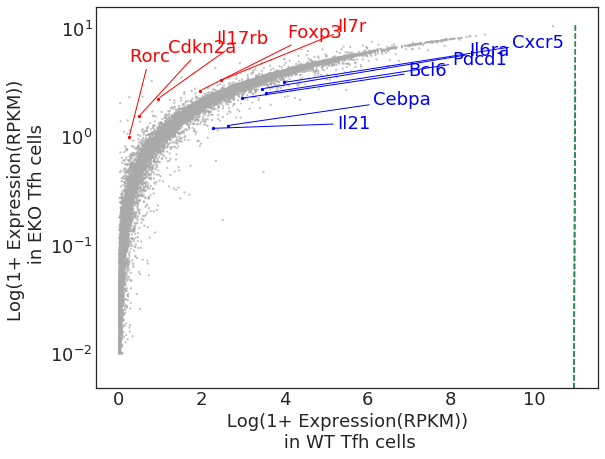

In [274]:
### Using Log1p(RPKM)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
ax.scatter(np.log1p(FPKM_Day8['WT_Tfh_Day8']), np.log1p(FPKM_Day8['EKO_Tfh_Day8'])
          , alpha=0.7,s=5, label='Tfh Day8',edgecolor='', c='darkgrey')
ax.set_xlabel(' Log(1+ Expression(RPKM)) \n in WT Tfh cells', fontsize='18')
ax.set_ylabel('Log(1+ Expression(RPKM)) \n in EKO Tfh cells', fontsize='18')

#ax.legend(loc=2, fontsize=16)


Up_highlight_index_set=['Rorc', 'Cdkn2a', 'Il17rb', 'Foxp3', 'Il7r']
down_highlight_index_set=['Il21', 'Cebpa', 'Bcl6','Pdcd1','Il6ra', 'Cxcr5' ]


i=0
for highlight_index in Up_highlight_index_set:
    #print highlight_index
    ax.scatter( np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8'] ),
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8']),
            alpha=1.0,s=5,color='r', label=highlight_index,edgecolor='r')
                  
    ax.annotate(highlight_index, color='r', fontsize='18', arrowprops=dict(facecolor='None', edgecolor='red', arrowstyle='-'),
               xy=(np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8'] ),
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8'])), 
               xytext=(np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8'])+0.7*i,
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8'])+ 4.0+ 0.5*i))
    i+=1

i=0
for highlight_index in down_highlight_index_set:
    #print highlight_index
    ax.scatter( np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8'] ),
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8']),
            alpha=1.0,s=5, color='blue', label=highlight_index,edgecolor='blue')
    
    ax.annotate(highlight_index, color='b', fontsize='18', arrowprops=dict(facecolor='None', edgecolor='blue', arrowstyle='-'),
               xy=(np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8'] ),
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8'])), 
               xytext=(np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_Tfh_Day8']) + 3.0 + 0.5*i,
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['EKO_Tfh_Day8'])+0.7*i))
    i+=1

ax.tick_params(axis = 'both', which = 'major', labelsize = 18)


ax.plot([0,11], [0,11], ls="--", c="seagreen") ## diagnol
ax.plot([0,11], [np.log1p(0),np.log1p(22)], ls="--", c="seagreen") ## Slope= fold change = 2
ax.plot([0,11], [0,11], ls="--", c="seagreen") ## Slope= fold change = 1/2
ax.set_yscale('log')
ax.set_scale('log')
#ax.xaxis(fontsize=20)
#ax[1].plot([0,10], [0, 10], ls="--", c="seagreen")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].scatter(np.log1p (FPKM_Day4['WT_CD8_Day4']), np.log1p(FPKM_Day4['RKO_CD8_Day4']),
              alpha=0.7,s=5, label='CD8 Day4',edgecolor='', c='darkgrey')
#ax[0].set_xlim(-0.1*range_limit,range_limit)
#ax[0].set_ylim(-0.1*range_limit,range_limit)
ax[0].set_xlabel('WT_RPKM')
ax[0].set_ylabel('RKO_RPKM')
#ax[0].set_title(retrotransposon_name+': '+str(len(df1))+' elements')
#ax[0].plot([-100,range_limit], [-100, range_limit], ls="--", c=".3")
ax[0].legend(loc=2, fontsize=16)



ax[1].scatter(np.log1p (FPKM_Day8['WT_CD8_Day8']), np.log1p(FPKM_Day8['RKO_CD8_Day8']),
              alpha=0.7,s=5, label='CD8 Day8',edgecolor='', c='darkgrey')
#ax[0].set_xlim(-0.1*range_limit,range_limit)
#ax[0].set_ylim(-0.1*range_limit,range_limit)
ax[1].set_xlabel('WT_RPKM')
ax[1].set_ylabel('RKO_RPKM')
#ax[0].set_title(retrotransposon_name+': '+str(len(df1))+' elements')
#ax[0].plot([-100,range_limit], [-100, range_limit], ls="--", c=".3")
ax[1].legend(loc=2, fontsize=16)


###  highlight a point


#ax[0].scatter( np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['WT_CD8_Day4'] ),
#                np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['RKO_CD8_Day4']),
#            alpha=1.0,s=50,color='blue', label=highlight_index,edgecolor='blue')
#ax[0].text( np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['WT_CD8_Day4']) -0.5,
#                np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['RKO_CD8_Day4'])+ 0.5 , highlight_index, fontsize=14, color='b')

#Up_highlight_index_set=( 'Tcf7' , 'll21', 'Cxcr5', 'Maf' )
#down_highlight_index_set=( 'Gzmb', 'Cd8b1', 'Ccnd2', 'Prdm1' )
#####################################################################################################
#Up_highlight_index_set= [ 'Tcf7', 'Il21', 'Cxcr5', 'Maf']
#down_highlight_index_set=['Gzmb', 'Cd8b1', 'Ccnd2', 'Prdm1']
Up_highlight_index_set=[ 'Cdkn2a', 'Foxp3', 'Rorc', 'Il17rb', 'Il7r']
down_highlight_index_set=['Bcl6','Cxcr5','Il6ra','Pdcd1', 'Il21', 'Cebpa']



for highlight_index in Up_highlight_index_set:
    print highlight_index
    ax[0].annotate(highlight_index, color='r', fontsize='14', arrowprops=dict(facecolor='None', edgecolor='red', arrowstyle='fancy'),
               xy=(np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['WT_CD8_Day4'] ),
                np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['RKO_CD8_Day4'])), 
               xytext=(np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['WT_CD8_Day4']) -1.5,
                np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['RKO_CD8_Day4'])+ 1.5))
    
    
    ax[1].annotate(highlight_index, color='r', fontsize='14', arrowprops=dict(facecolor='None', edgecolor='red', arrowstyle='fancy'),
               xy=(np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_CD8_Day8'] ),
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['RKO_CD8_Day8'])), 
               xytext=(np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_CD8_Day8']) -1.5,
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['RKO_CD8_Day8'])+ 1.5))

for highlight_index in down_highlight_index_set:
    print highlight_index
    ax[0].annotate(highlight_index, color='b', fontsize='14', arrowprops=dict(facecolor='None', edgecolor='blue', arrowstyle='fancy'),
               xy=(np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['WT_CD8_Day4'] ),
                np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['RKO_CD8_Day4'])), 
               xytext=(np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['WT_CD8_Day4']) +1.5,
                np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['RKO_CD8_Day4'])- 1.5))
    
    
    ax[1].annotate(highlight_index, color='b', fontsize='14', arrowprops=dict(facecolor='None', edgecolor='blue', arrowstyle='fancy'),
               xy=(np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_CD8_Day8'] ),
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['RKO_CD8_Day8'])), 
               xytext=(np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['WT_CD8_Day8']) +1.5,
                np.log1p(FPKM_Day8[FPKM_Day8['gene_id'] == highlight_index]['RKO_CD8_Day8']) - 1.5))




#ax[1].scatter( np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['WT_CD8_Day4']),
#                np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['RKO_CD8_Day4']),
#            alpha=1.0,s=50,color='blue', label=highlight_index,edgecolor='blue')
#ax[1].text( np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['WT_CD8_Day4'])-0.5,
#                np.log1p(FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['RKO_CD8_Day4'])+0.5, highlight_index, fontsize=14, color='b')
###







ax[0].plot([0,10], [0, 10], ls="--", c="seagreen")
ax[1].plot([0,10], [0, 10], ls="--", c="seagreen")

In [36]:
highlight_index='Prdm1'
FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]

,gene_id,WT_CD8_Day4_0,WT_CD8_Day4_1,RKO_CD8_Day4_0,RKO_CD8_Day4_1,WT_CD8_Day4,RKO_CD8_Day4
17251,Prdm1,15.0222,16.1589,6.46793,6.01822,15.59055,6.243075


In [54]:
FPKM_Day4[FPKM_Day4['gene_id'] == highlight_index]['WT_CD8_Day4']

21006    63.0118
Name: WT_CD8_Day4, dtype: float64

In [ ]:
    highlight_index='Foxp3'
    df_gene_Only_Foxp3_WT[df_gene_Only_Foxp3_WT.index == highlight_index]
    # Calculate the point density
    fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=True)

    range_limit=1000
    xy = np.vstack([df_gene_Intersection_WT, df_gene_Intersection_KO])
    z = gaussian_kde(xy)(xy)

    axis[1].axis('equal')
    cax_1 = axis[1].scatter(df_gene_Intersection_WT, df_gene_Intersection_KO, alpha=1.0,s=5,c=z, label='Intersection',edgecolor='')
    
    ###  highlight a point
    highlight_index='Tcf7'
    axis[1].scatter(df_gene_Intersection_WT[df_gene_Intersection_WT.index == highlight_index],
                df_gene_Intersection_KO[df_gene_Intersection_KO.index == highlight_index],
                alpha=1.0,s=50,color='blue', label=highlight_index,edgecolor='blue')
    axis[1].text(df_gene_Intersection_WT[df_gene_Intersection_WT.index == highlight_index]+range_limit/20,
                df_gene_Intersection_KO[df_gene_Intersection_KO.index == highlight_index]-range_limit/20, highlight_index, fontsize=14)
    ###
    
    axis[1].set_title('Intersection: '+ str(len(df_gene_Intersection_WT)) + ' elements')
    axis[1].plot([0,range_limit], [0, range_limit], ls="--", c=".3")
    
    
    
    
    axis[0].axis('equal')
    xy = np.vstack([df_gene_Only_Foxp3_WT, df_gene_Only_Foxp3_KO])
    z = gaussian_kde(xy)(xy)
    cax_0 = axis[0].scatter(df_gene_Only_Foxp3_WT, df_gene_Only_Foxp3_KO, alpha=1.0,s=5, c=z, label='Only_Foxp3',edgecolor='')
    axis[0].set_title('Only_Foxp3: ' + str(len(df_gene_Only_Foxp3_WT))+' elements')
    axis[0].plot([0,range_limit], [0, range_limit], ls="--", c=".3")
    
    ###  highlight a point
    highlight_index='Foxp3'
    axis[0].scatter(df_gene_Only_Foxp3_WT[df_gene_Only_Foxp3_WT.index == highlight_index],
                df_gene_Only_Foxp3_KO[df_gene_Only_Foxp3_KO.index == highlight_index],
                alpha=1.0,s=50,color='blue', label=highlight_index,edgecolor='blue')
    axis[0].text(df_gene_Only_Foxp3_WT[df_gene_Only_Foxp3_WT.index == highlight_index]+range_limit/20,
                df_gene_Only_Foxp3_KO[df_gene_Only_Foxp3_KO.index == highlight_index]-range_limit/20, highlight_index, fontsize=14)
    ###
    

    axis[2].axis('equal')
    xy = np.vstack([df_gene_Only_Tcf1_WT, df_gene_Only_Tcf1_KO])
    z = gaussian_kde(xy)(xy)
    cax_2 = axis[2].scatter(df_gene_Only_Tcf1_WT, df_gene_Only_Tcf1_KO, alpha=1.0,s=5, c=z, label='Only_Tcf1',edgecolor='')
    axis[2].set_title( 'Only_Tcf1: '+str(len(df_gene_Only_Tcf1_WT))+' elements')
    axis[2].plot([0,range_limit], [0, range_limit], ls="--", c=".3")
    
    for ax in axis:
            ax.yaxis.grid(True)
            ax.set_ylim(-50,range_limit)
            ax.set_xlim(-50,range_limit)
            ax.set_xlabel('WT_RPKM')
            ax.set_ylabel('KO_RPKM')

fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7]) # A 4-length sequence of [left, bottom, width, height] quantities.
#fig.colorbar(cax=cbar_ax)




In [11]:
#FPKM_Day8.head
 
# Calculate the point density
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

ax[0].scatter(RPKM_12.iloc[:,[1]], RPKM_12.iloc[:,[2]], alpha=1.0,s=5,c=z, label='H3K4',edgecolor='')
ax[0].set_xlim(-0.1*range_limit,range_limit)
ax[0].set_ylim(-0.1*range_limit,range_limit)
ax[0].set_xlabel('WT_RPKM')
ax[0].set_ylabel('KO_RPKM')
ax[0].set_title(retrotransposon_name+': '+str(len(df1))+' elements')
ax[0].plot([-100,range_limit], [-100, range_limit], ls="--", c=".3")
ax[0].legend(loc=2, fontsize=16)


## Generate Excel file contains all genes, and DEGs. 

In [5]:
PATH_FOLDER=os.getcwd()+ '/CuffDiff_Results/'
OUT_FOLDER=os.getcwd()+'/genelist/'

DIR_CHECK_CREATE(PATH_FOLDER)
DIR_CHECK_CREATE(OUT_FOLDER)


INPUT_LIST=os.listdir(PATH_FOLDER)
writer = pd.ExcelWriter(OUT_FOLDER+'CD8-HP_CuffDiff_Summary201806.xlsx', engine='xlsxwriter')

i=0
for input_name in INPUT_LIST[:]:
    INPUT_PATH = PATH_FOLDER+input_name
    if (i==0):
        df_all=generate_genes_FPKM_df(INPUT_PATH)
        df_all[input_name]=''
        df_all = df_all.merge(generate_All_Genes(INPUT_PATH,i+1), on='gene_id', how='inner', suffixes=('','_')) 
        i+=1
        continue
    df_all = df_all.merge(generate_genes_FPKM_df(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_'))
    df_all[input_name]=''
    df_all = df_all.merge(generate_All_Genes(INPUT_PATH,i+1), on='gene_id', how='inner', suffixes=('','_')) 
    
    i+=1
df_all.to_excel(writer, sheet_name='All_Genes', index=None)



###### Generating a DEGs list in the last.
DEGs_List=pd.DataFrame([],columns=['gene_id'])


for input_name in INPUT_LIST:
    INPUT_PATH = PATH_FOLDER+input_name
    print ('Library:' + input_name)
    df_up = generate_genes_FPKM_df(INPUT_PATH)
    df_up[input_name]=''
    df_up = df_up.merge(generate_Upregulated_Genes(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_'))
    df_up.to_excel( writer, sheet_name='up_'+input_name, index=None)
    
    DEGs_List=pd.concat([DEGs_List,df_up[['gene_id']]])
    print ('# of Up:' )
    print(df_up.shape)
    
    df_down = generate_genes_FPKM_df(INPUT_PATH)
    df_down[input_name]=''
    df_down = df_down.merge(generate_Downregulated_Genes(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_')) 
    df_down.to_excel( writer, sheet_name='down_'+input_name,index=None)
    DEGs_List=pd.concat([DEGs_List,df_down[['gene_id']]])
    print ('# of Down')
    print(df_down.shape)
    print ('')

print ("Total Number of DEGs is:" + str(len(DEGs_List['gene_id'].unique())))

DEGs_List = pd.DataFrame( list(DEGs_List['gene_id'].unique()), columns=['gene_id'])
DEGs_List.to_excel( writer, sheet_name='Union_DGEs_List',index=None)

writer.save()

Dir Exists
Dir Exists
Library:DKO_0h_vs_WT_0h
# of Up:
(647, 13)
# of Down
(705, 13)

Library:DKO_72h_vs_DKO_0h
# of Up:
(1457, 13)
# of Down
(1026, 13)

Library:Ref_DKO_1_2_4n_vs_Ctrl_34n
# of Up:
(1601, 12)
# of Down
(1575, 12)

Library:DKO_72h_vs_WT_72h
# of Up:
(441, 13)
# of Down
(749, 13)

Library:WT_72h_vs_WT_0h
# of Up:
(1812, 13)
# of Down
(1272, 13)

Total Number of DEGs is:5624


In [9]:
#### Generate DEGs Seperately

#os.makedirs(os.getcwd()+'/genelist/')
PATH_FOLDER=os.getcwd()+ '/CuffDiff_Results/'
INPUT_LIST=os.listdir(PATH_FOLDER)
for input_name in INPUT_LIST:
    INPUT_PATH = PATH_FOLDER+input_name
    print ('Library:' + input_name)
    df_up = generate_Upregulated_Genes(INPUT_PATH)
    df_up.to_csv( os.getcwd()+'/genelist/up_'+input_name +'.bed' ,sep='\t')
    print ('# of Up:' )
    print(df_up.shape)
    
    df_down = generate_Downregulated_Genes(INPUT_PATH)  
    df_down.to_csv( os.getcwd()+'/genelist/down_'+input_name + '.bed' ,sep='\t')
    print ('# of Down')
    print(df_down.shape)
    print ('')


Library:DKO_0h_vs_WT_0h
# of Up:
(647, 6)
# of Down
(705, 6)

Library:DKO_72h_vs_DKO_0h
# of Up:
(1457, 6)
# of Down
(1026, 6)

Library:Ref_DKO_1_2_4n_vs_Ctrl_34n
# of Up:
(1601, 6)
# of Down
(1575, 6)

Library:DKO_72h_vs_WT_72h
# of Up:
(441, 6)
# of Down
(749, 6)

Library:WT_72h_vs_WT_0h
# of Up:
(1812, 6)
# of Down
(1272, 6)



### Test output Results

In [25]:
df_all=generate_genes_FPKM_df(INPUT_PATH)
df_down = generate_genes_FPKM_df(INPUT_PATH)
df_down[df_down['gene_id']=='Rnaset2a,Rnaset2b']

,gene_id,WT_0h_0,WT_0h_1,WT_0h_2,WT_72h_0,WT_72h_1,WT_72h_2


#### ALL DEGs Generating

In [13]:
[INPUT_LIST[1],INPUT_LIST[3]]

['DKO_0h_vs_WT_0h', 'DKO_72h_vs_WT_72h']

In [4]:
####Generating  FPKM of all DEGs replicates
DIR_CHECK_CREATE(os.getcwd()+'/genelist/')
PATH_FOLDER=os.getcwd()+ '/CuffDiff_Results/'
INPUT_LIST=os.listdir(PATH_FOLDER)

DEGs_INPUT_LIST=[INPUT_LIST[1],INPUT_LIST[3]]
DEGs_INPUT_LIST=INPUT_LIST

#DEGs_List
df_ALL_DEGs=DEGs_List

for input_name in DEGs_INPUT_LIST:
    INPUT_PATH = PATH_FOLDER+input_name
    print ('Library:' + input_name)
    df_ALL_DEGs = df_ALL_DEGs.merge(generate_genes_FPKM_df(INPUT_PATH), on='gene_id',how='inner')



print ('# of DEGs:' )
print(df_ALL_DEGs.shape)
df_ALL_DEGs=df_ALL_DEGs.set_index('gene_id')


Dir Exists
Library:DKO_0h_vs_WT_0h
Library:DKO_72h_vs_DKO_0h
Library:Ref_DKO_1_2_4n_vs_Ctrl_34n
Library:DKO_72h_vs_WT_72h
Library:WT_72h_vs_WT_0h
# of DEGs:
(5624, 30)


## From above we can continue using:
# "df_ALL_DEGs" for plot

# Plot Part

In [3]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

In [5]:
def Generate_Venn_Diagram(Raw_Path, Out_Path, Merge_Column):
    from matplotlib_venn import venn2
    
    DIR_CHECK_CREATE(Raw_Path)
    DIR_CHECK_CREATE(Out_Path)
    Merge_Column='gene_id'
    
    INPUT_LIST=os.listdir(RAW_PATH)
    FILE_TYPE=INPUT_LIST[0][-4:]
    print('Input File: ' )
    print(INPUT_LIST)
    
    if len(INPUT_LIST) == 2:
        print ('Input Two, Continue.')
        PATH_A = RAW_PATH + '/' +INPUT_LIST[0]
        PATH_B = RAW_PATH + '/' +INPUT_LIST[1]

        df_A = pd.read_csv(PATH_A,sep='\t')
        df_B = pd.read_csv(PATH_B,sep='\t')

        ### Union A and B, use indicator to differentiate them.
        union_A_B=df_A.loc[:, [Merge_Column]].merge(df_B.loc[:,[Merge_Column]], how='outer', indicator=True)

        intersection_A_B=union_A_B[union_A_B['_merge']=='both']
        only_A=union_A_B[union_A_B['_merge']=='left_only']
        only_B=union_A_B[union_A_B['_merge']=='right_only']

        #Output
        intersection_A_B.to_csv(OUT_PATH+'/Intersection_'+INPUT_LIST[0][:-4]+'_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        only_A.to_csv(OUT_PATH+'/Only_'+INPUT_LIST[0][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        only_B.to_csv(OUT_PATH+'/Only_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        union_A_B.to_csv(OUT_PATH+'/Union_'+INPUT_LIST[0][:-4]+'_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
    else:
        print('Error!')
        print('Input '+str(len(INPUT_LIST))+ ' Files')


    out = venn2(subsets=(len(only_A[Merge_Column]), len(only_B[Merge_Column]), len(intersection_A_B[Merge_Column])),
          set_labels=(INPUT_LIST[0][:-4], INPUT_LIST[1][:-4] ) )
    for text in out.subset_labels:
        text.set_fontsize(18)
    plt.show()

Dir Exists
Dir Exists
Input File: 
['up_DKO_0h_vs_WT_0h.bed', 'Up_DKO_CD8_0h_over_WT_CD8_0h_ZZ.bed']
Input Two, Continue.


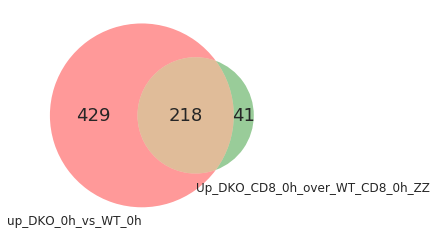

In [14]:
Folder_Name='Up'
RAW_PATH=os.getcwd() + '/Venn_Results_WT_0h_DKO_0h_vs_ZZ_2016/' + Folder_Name
OUT_PATH=os.getcwd() + '/Venn_Results_WT_0h_DKO_0h_vs_ZZ_2016/Results_' + Folder_Name

Generate_Venn_Diagram(RAW_PATH, OUT_PATH, 'gene_id')

# heatmap

(5623, 29)

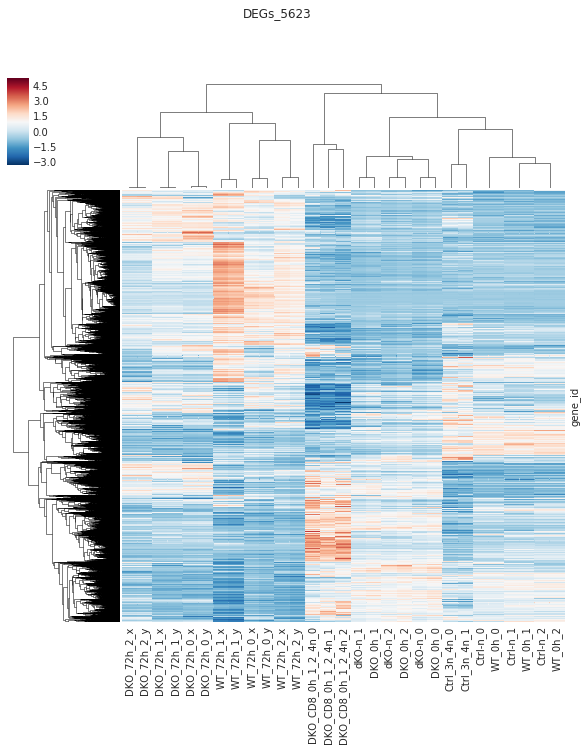

In [15]:
### Drop all zeros rows for plot
Heatmap_Df = df_ALL_DEGs.loc[(df_ALL_DEGs!=0).any(axis=1)]

Heatmap_Name='DEGs_'+str(len(Heatmap_Df.index))
#### Very Important

#Heatmap_Df=FPKM_df.fillna(0)

fig_1 = sns.clustermap(Heatmap_Df,  yticklabels=False, z_score=0, col_cluster=True, cmap='RdBu_r' )
fig_1.savefig(Heatmap_Name+'.png')
fig_1.fig.suptitle(Heatmap_Name)
Heatmap_Df.shape

# PCA



## Input a DataFrame then plot.

In [16]:
# PCA
df_2 = df_ALL_DEGs #.reset_index()

#### Remove unicode of list in python 
df2_gene_id = [x.encode('ascii', 'ignore') for x in df_2.index]


from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

#### In here we set targets as the name of columns, which means our purpose is to compare \
#### the relationship between different columns.
targets= [x.encode('ascii', 'ignore') for x in df_2.columns]

colors=[]
for i in range(len(targets)):
    colors.append( "C"+ str(i))
    #print(colors[i])

################################################################################

df_2_T = df_2.transpose()

# Separating out the features
x = df_2_T.loc[ :, df2_gene_id ].values


# Separating out the target
y = df_2_T.loc[targets,:].values


# Standardizing the featuresbio
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


########### THIS is fucking killing me. reindex df with df2, just using following command.
principalDf.index = df_2_T.index

#finalDf = pd.concat( [principalDf, df_2_T.loc['target']], axis = 1)
principalDf

,principal component 1,principal component 2
Ctrl_3n_4n_0,-9.611481,-60.351322
Ctrl_3n_4n_1,-8.146160,-57.424568
DKO_CD8_0h_1_2_4n_0,-59.608932,67.053024
DKO_CD8_0h_1_2_4n_1,-64.376341,54.908210
DKO_CD8_0h_1_2_4n_2,-72.795119,55.085117
Ctrl-n_0,-27.296778,-46.508727
Ctrl-n_1,-31.645623,-41.528416
Ctrl-n_2,-32.462886,-41.049033
dKO-n_2,-46.108241,7.843257
dKO-n_0,-47.306553,11.530231


(5623, 29)

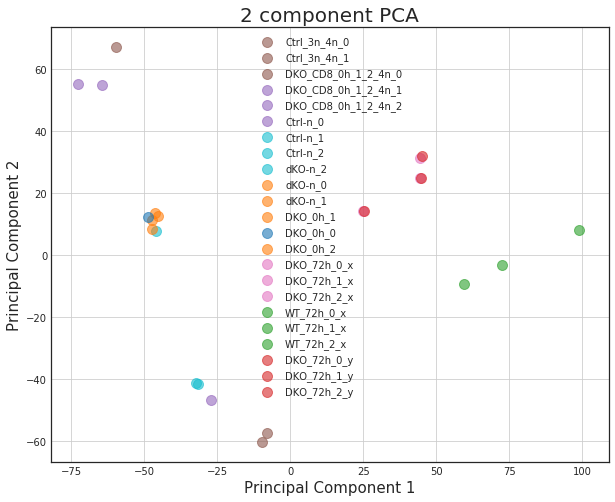

In [17]:
### PLOT

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

colors = ['C5','C5','C5',
          'C4','C4','C4',
          'C9','C9','C9',
          'C1','C1','C1',
          'C0','C1', 
          'C6','C6','C6',
          'C2','C2','C2',
          'C3','C3','C3']

for target, color in zip( targets,colors):
    indicesToKeep = principalDf.index == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , s = 100, c=color, alpha=0.6)
ax.legend(targets)
#ax.set_xlim(-2,8)
ax.grid()
Parameters_Detail='CD8_HP'
fig.savefig('PCA'+Parameters_Detail+'.png')
df_ALL_DEGs.shape

## Violin Plot

In [ ]:
all_data=[np.log1p((df3.iloc[:,0])), np.log1p((df2.iloc[:,0]))]

y_max, y_min = (max( [max(x)  for x in all_data ]), min( [min(x)  for x in all_data ]))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.violinplot( all_data,showmeans=False,showmedians=True)
axes.grid(color='grey', linestyle='dashed', linewidth=0.5)
#axes.set_xlabel('Frequency')
axes.set_ylabel('log1p(RPKM)')
axes.set_ylim(y_min-1,y_max+1)



plt.setp(axes, xticks=[y + 1 for y in range(len(all_data))],
         xticklabels=['Intersection_'+str(len(all_data[0])), 'Only_Tcf1_'+str(len(all_data[1]))])



from scipy import stats
MWU, pvalue = ( stats.mannwhitneyu((df3.iloc[:,0]), (df2.iloc[:,0]), alternative=None )[0], 
                stats.mannwhitneyu((df3.iloc[:,0]), (df2.iloc[:,0]), alternative='two-sided')[1])
#print "U= %d p = %.1e" % (MWU, pvalue)

if float("%.1e" % pvalue) == 1.0:
    plt.text(0.1, r'p = 1.0', fontsize=15)
    print('P_value is: %.1e' % pvalue )
else:
    if pvalue !=0:
        sign = '='
        digit, exp = re.search(r'(\S+)e(\S+)' , '%.1e' % pvalue).group(1,2)
    else:
        sign, digit, exp = '<', '1.0', '-300'
        print('P_value is: %.1e' % pvalue )
        plt.text( 1.1, (y_max+0.5) , r'P_value {} {} x $10^{{{}}}$'.format(sign, digit, int(exp)), fontsize=15)
        

In [ ]:
df0_a = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_CD4_TCF1_20160827000_genelist_Only_Foxp3_5k.csv', sep='\t', header=0)
df0_a = df0_a.set_index('gene_id').dropna(axis=0, how='any')
df0_a = df0_a.loc[ (df0_a['RPKM'] > 0 ) ]
df0_a = df0_a.rename(columns={'RPKM':'RPKM_WT_Only_Foxp3'})

df0_b = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_TKOCD4_TCF1_20160827000_genelist_Only_Foxp3_5k.csv', sep='\t', header=0)
df0_b = df0_b.set_index('gene_id').dropna(axis=0, how='any')
df0_b = df0_b.loc[ (df0_b['RPKM'] > 0 ) ]
df0_b = df0_b.rename(columns={'RPKM':'RPKM_KO_Only_Foxp3'})

###################################################################################################################
df1_a = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_CD4_TCF1_20160827000_genelist_Intersection_Foxp3_5k_Treg_TCF1.csv', sep='\t', header=0)
df1_a = df1_a.set_index('gene_id').dropna(axis=0, how='any')
df1_a = df1_a.loc[ (df1_a['RPKM'] > 0 ) ]
df1_a = df1_a.rename(columns={'RPKM':'RPKM_WT_Intersection'})

df1_b = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_TKOCD4_TCF1_20160827000_genelist_Intersection_Foxp3_5k_Treg_TCF1.csv', sep='\t', header=0)
df1_b = df1_b.set_index('gene_id').dropna(axis=0, how='any')
df1_b = df1_b.loc[ (df1_b['RPKM'] > 0 ) ]
df1_b = df1_b.rename(columns={'RPKM':'RPKM_KO_Intersection'})

###################################################################################################################
df2_a = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_CD4_TCF1_20160827000_genelist_Only_Treg_TCF1.csv', sep='\t', header=0)
df2_a = df2_a.set_index('gene_id').dropna(axis=0, how='any')
df2_a = df2_a.loc[ (df2_a['RPKM'] > 0 ) ]
df2_a = df2_a.rename(columns={'RPKM':'RPKM_WT_Only_Treg'})

df2_b = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_TKOCD4_TCF1_20160827000_genelist_Only_Treg_TCF1.csv', sep='\t', header=0)
df2_b = df2_b.set_index('gene_id').dropna(axis=0, how='any')
df2_b = df2_b.loc[ (df2_b['RPKM'] > 0 ) ]
df2_b = df2_b.rename(columns={'RPKM':'RPKM_KO_Only_Treg'})

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

axes[0,0].violinplot(  (np.log10(df0_a.iloc[:,0])),showmeans=False,showmedians=True )
axes[0,0].set_title('gene_list_WT_Only_FoxP3_'+str(len(df0_a)))

axes[1,0].violinplot( ( np.log10(df0_b.iloc[:,0] )),showmeans=False,showmedians=True)
axes[1,0].set_title('gene_list_KO_Only_FoxP3_'+str(len(df0_b)))



axes[0,1].violinplot( ( np.log10(df1_a.iloc[:,0] )),showmeans=False,showmedians=True)
axes[0,1].set_title('gene_list_WT_Intersection_'+str(len(df1_a)))

axes[1,1].violinplot( ( np.log10(df1_b.iloc[:,0] )),showmeans=False,showmedians=True)
axes[1,1].set_title('gene_list_KO_Intersection_'+str(len(df1_b)))



axes[0,2].violinplot( ( np.log10(df2_a.iloc[:,0] )),showmeans=False,showmedians=True)
axes[0,2].set_title('gene_list_WT_Only_Treg_'+str(len(df2_a)))

axes[1,2].violinplot( ( np.log10(df2_b.iloc[:,0] )),showmeans=False,showmedians=True)
axes[1,2].set_title('gene_list_KO_Only_Treg_'+str(len(df2_b)))



for i in range(2):
    for j in range(3):
        ax=axes[i,j]
        ax.yaxis.grid(True)
        #ax.set_xticks([y + 1 for y in range(max(df1))])
        ax.set_ylim(-0.5,2)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('log10(RPKM)')

fig.savefig('gene_list_WT_KO.png') 

# Scattering Plot + Heatmap

In [ ]:
from scipy.stats import gaussian_kde
        # Calculate the point density
    fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=True)

    range_limit=1000
    xy = np.vstack([df_gene_Intersection_WT, df_gene_Intersection_KO])
    z = gaussian_kde(xy)(xy)

    axis[1].axis('equal')
    cax_1 = axis[1].scatter(df_gene_Intersection_WT, df_gene_Intersection_KO, alpha=1.0,s=5,c=z, label='Intersection',edgecolor='')
    
    ###  highlight a point
    highlight_index='Tcf7'
    axis[1].scatter(df_gene_Intersection_WT[df_gene_Intersection_WT.index == highlight_index],
                df_gene_Intersection_KO[df_gene_Intersection_KO.index == highlight_index],
                alpha=1.0,s=50,color='blue', label=highlight_index,edgecolor='blue')
    axis[1].text(df_gene_Intersection_WT[df_gene_Intersection_WT.index == highlight_index]+range_limit/20,
                df_gene_Intersection_KO[df_gene_Intersection_KO.index == highlight_index]-range_limit/20, highlight_index, fontsize=14)
    ###
    
    axis[1].set_title('Intersection: '+ str(len(df_gene_Intersection_WT)) + ' elements')
    axis[1].plot([0,range_limit], [0, range_limit], ls="--", c=".3")
    
    
    
    
    axis[0].axis('equal')
    xy = np.vstack([df_gene_Only_Foxp3_WT, df_gene_Only_Foxp3_KO])
    z = gaussian_kde(xy)(xy)
    cax_0 = axis[0].scatter(df_gene_Only_Foxp3_WT, df_gene_Only_Foxp3_KO, alpha=1.0,s=5, c=z, label='Only_Foxp3',edgecolor='')
    axis[0].set_title('Only_Foxp3: ' + str(len(df_gene_Only_Foxp3_WT))+' elements')
    axis[0].plot([0,range_limit], [0, range_limit], ls="--", c=".3")
    

    axis[2].axis('equal')
    xy = np.vstack([df_gene_Only_Tcf1_WT, df_gene_Only_Tcf1_KO])
    z = gaussian_kde(xy)(xy)
    cax_2 = axis[2].scatter(df_gene_Only_Tcf1_WT, df_gene_Only_Tcf1_KO, alpha=1.0,s=5, c=z, label='Only_Tcf1',edgecolor='')
    axis[2].set_title( 'Only_Tcf1: '+str(len(df_gene_Only_Tcf1_WT))+' elements')
    axis[2].plot([0,range_limit], [0, range_limit], ls="--", c=".3")
    
    for ax in axis:
            ax.yaxis.grid(True)
            ax.set_ylim(-50,range_limit)
            ax.set_xlim(-50,range_limit)
            ax.set_xlabel('WT_RPKM')
            ax.set_ylabel('KO_RPKM')

fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7]) # A 4-length sequence of [left, bottom, width, height] quantities.
#fig.colorbar(cax=cbar_ax)



    